**Распознавание рукописного ввода на примере базы MNIST**

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук 002-digit.ipynb.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

# Library

In [1]:
import tensorflow as tf
from sklearn.preprocessing import normalize
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [2]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load data

In [3]:
!pip install -q kaggle

from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/kaggle.json
!kaggle competitions download -c digit-recognizer

mkdir: cannot create directory ‘/root/.kaggle’: File exists
digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import zipfile

z = zipfile.ZipFile('digit-recognizer.zip')
z.printdir()

File Name                                             Modified             Size
sample_submission.csv                          2019-12-11 20:01:20       240909
test.csv                                       2019-12-11 20:01:20     51118296
train.csv                                      2019-12-11 20:01:24     76775041


In [6]:
z.extract('train.csv')
z.extract('test.csv')

'/content/test.csv'

In [7]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

# Preprocessing data

In [8]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))
train_img.shape

(42000, 28, 28)

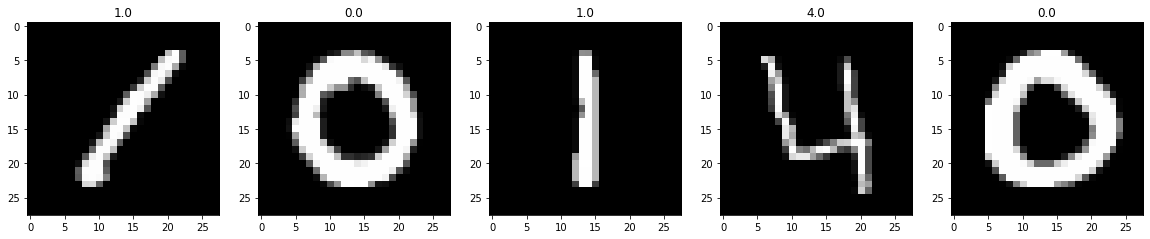

In [9]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [10]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [11]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [12]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

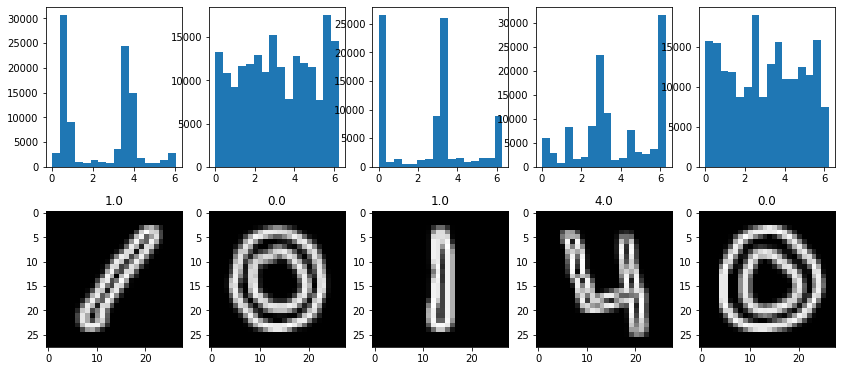

In [13]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

In [14]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [15]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

In [16]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

In [17]:
train_hist.shape

(42000, 16)

# Modeling

In [18]:
model = Sequential()
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

In [21]:
X_train_normalized = normalize(train_hist)
y_train_labels = tf.keras.utils.to_categorical(train_label)
history = model.fit(X_train_normalized, y_train_labels, validation_split=0.1, epochs=20, verbose=1)

Epoch 1/20
1182/1182 [==============================] - 4s 3ms/step - loss: 1.4359 - accuracy: 0.4660 - val_loss: 1.1820 - val_accuracy: 0.5664
Epoch 2/20
1182/1182 [==============================] - 4s 3ms/step - loss: 1.1793 - accuracy: 0.5675 - val_loss: 1.1047 - val_accuracy: 0.5924
Epoch 3/20
1182/1182 [==============================] - 5s 4ms/step - loss: 1.1291 - accuracy: 0.5879 - val_loss: 1.0852 - val_accuracy: 0.6029
Epoch 4/20
1182/1182 [==============================] - 4s 4ms/step - loss: 1.1052 - accuracy: 0.5988 - val_loss: 1.0569 - val_accuracy: 0.6131
Epoch 5/20
1182/1182 [==============================] - 3s 2ms/step - loss: 1.0831 - accuracy: 0.6066 - val_loss: 1.0474 - val_accuracy: 0.6150
Epoch 6/20
1182/1182 [==============================] - 3s 2ms/step - loss: 1.0713 - accuracy: 0.6120 - val_loss: 1.0326 - val_accuracy: 0.6236
Epoch 7/20
1182/1182 [==============================] - 3s 2ms/step - loss: 1.0634 - accuracy: 0.6171 - val_loss: 1.0384 - val_accuracy:

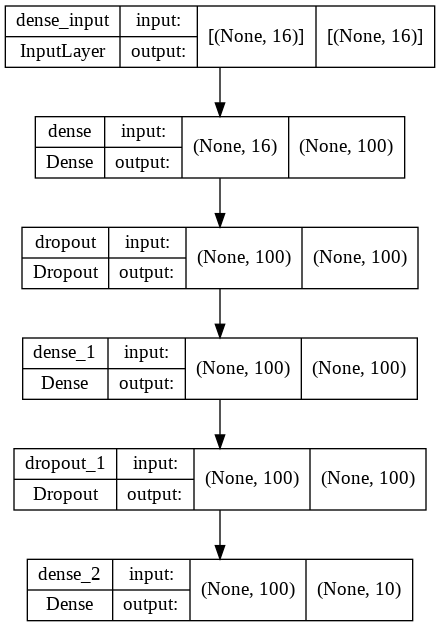

In [22]:
tf.keras.utils.plot_model(model, "model_info.png", show_shapes=True)

# Predict

In [23]:
X_test_normalized = normalize(test_hist)
y_pred = model.predict(X_test_normalized)
y_pred_labels = np.argmax(y_pred, axis=1)

In [24]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_pred_labels, 1):
        dst.write('%s,%s\n' % (i, p))

In [25]:
!head submit.txt

ImageId,Label
1,5
2,5
3,9
4,0
5,3
6,7
7,0
8,3
9,8
